# Temperatura

Para ver el concepto de Temperatura y Cambio Climático revise la [Introduccion](Introduction.ipynb).
+ Mapas de Temperatura Media de años recientes de cada departamento.
+ Gráfico de Tendencia de la Temperatura Promedio de Colombia.

## Mapas de Temperatura Media

In [7]:
#Se descargan las librerias necesarias 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cartopy as cart
import scipy.stats #Metodos estadisticos
import matplotlib.colors as colors #Set Colors
import wradlib.ipol as ipol #Metodo de Interpolación

# El metodo para aplicar gradiente vertical de temperatura
def regresion(zi, altitude, nivel, coeficiente):
    temperature = []
    for ZI_item, altitude_item in zip(zi, altitude):
        if str(nivel) == 'altura_base':
            ZI_item = ZI_item - coeficiente*altitude_item
        elif str(nivel) == 'altura_real': 
            ZI_item = ZI_item + coeficiente*altitude_item
        #agregar elemento dentro de temperatura
        temperature.append(ZI_item)
    #se devuelve el valor de temperatura 
    return temperature 

class Mapa:  
    # El metodo inicial o constructor
    def __init__(self, departamento, year, mes, tipo, bol):
     
        # Instance Variable    
        self.departamento = departamento
        self.year = year
        self.mes = mes
        self.tipo = tipo
        self.normal = '1981-2010'
        self.bol = bol
        
    # El metodo para contruir mapas     
    def get_mapa(self, ax, periodo):
        
        #Se define la extensión del mapa
        if str(self.departamento) == 'Santander':
            lllat, urlat, lllon, urlon = 5.5, 8.5, -75, -72
            names = ['Bucaramanga','Piedecuesta','San Gil', 'Surata', 'Berlin']
            lon_m = [-73.1198, -73.0495, -73.133, -72.983, -72.8833]
            lat_m = [7.11392, 6.98743, 6.55, 7.367, 7.18333]
            idx_values = [66020, 60778, 43268, 76185, 68498]
            
        elif str(self.departamento) == 'Magdalena':
            lllat, urlat, lllon, urlon = 8.7, 11.5, -75.55, -73
            names = ['Santa Marta','Aracataca','Plato','El Banco']
            lon_m = [-74.22200, -74.18983, -74.78244, -73.97581]
            lat_m = [11.23500, 10.59181, 9.79029, 9.00114]
            idx_values = [110783,82787,47706,13166]
    
        #Se establece instancia de Cartopy    
        ax.set_extent([lllon, urlon, lllat, urlat], crs=cart.crs.PlateCarree())
        ax.add_feature(cart.feature.OCEAN, edgecolor='k', zorder = 2)#, facecolor = 'white')
    
        #Se dibujan los departamentos de Colombia
        fname = r".\DIVISION_COLOMBIA\MGN_DPTO_POLITICO.shp"
        adm1_shapes = list(cart.io.shapereader.Reader(fname).geometries())
        ax.add_geometries(adm1_shapes, cart.crs.PlateCarree(), edgecolor='black', facecolor='none', alpha=0.5)
                    
        #Se cargan los datos de las estaciones    
        df = pd.read_csv(str(r".\Datos\Temperatura\Temperatura_"+str(periodo)+".csv"))

        #Se seleccionan las estaciones que se ubiquen en el area del mapa 
        data = df.loc[(df['LONGITUD'] < urlon) & (df['LONGITUD'] > lllon)
                  & (df['LATITUD'] < urlat) & (df['LATITUD'] > lllat)]

        #Se remueven filas de dataframe que no contienen valores para el mes especifico
        data = data.dropna(subset=[str(self.mes)])

        #Se extrae los valores de coordenadas, altura y valor de cada estacion
        longitud = data['LONGITUD'].tolist()
        latitud = data['LATITUD'].tolist()
        elevacion = data['ELEVACION'].tolist()
        valor = data[str(self.mes)].tolist()
        src = np.vstack( (np.array(longitud), np.array(latitud)) ).transpose()

        #Se crea una grilla 300x300
        numcols, numrows = 350, 350
        xtrg = np.linspace(lllon, urlon, numcols)
        ytrg = np.linspace(lllat, urlat, numrows)
        trg = np.meshgrid(xtrg, ytrg)
        trg = np.vstack( (trg[0].ravel(), trg[1].ravel()) ).T

        #Se calcula el coeficiente de regresión entre altura y temperatura a partir de los datos de las estaciones 
        result = scipy.stats.linregress(np.array(elevacion), np.array(valor))
        coeficiente, r = result.slope, result.rvalue 
        if self.departamento == 'Magdalena' and r > -0.46:
            dg = pd.read_csv(str(r".\Regresion de Elevacion\Regresion_Temperatura_Magdalena_2018.csv"))
            coeficiente = dg[str(self.mes)][0] 
        z = regresion(valor, elevacion, "altura_base", coeficiente)
        
        #Se aplica el método de interpolación IDW (Inverse Distance Weighting)
        idw = ipol.Idw(src, trg)
        zi = idw(np.array(z))

        #Regresion a la altura Real
        data_hh = pd.read_csv(str(r".\Regresion de Elevacion\Elevacion_"+str(self.departamento)+".csv"))
        altitude = np.array(data_hh["Elevacion"].tolist())
        ZI = np.array(regresion(zi, altitude, "altura_real",coeficiente))
        
        #Se dibujan municipios mas importantes y sus respectivos valores
        ax.scatter(lon_m, lat_m, color = 'black', zorder = 3)
        for i, txt in enumerate(names):
            ax.annotate(txt, xy = (lon_m[i]-0.05, lat_m[i]), ha = 'right', va = 'center')
            if (self.bol == True and str(self.tipo) != "Anomalia") or (self.bol == True and str(periodo) == "1981-2010"):
                ax.annotate(round(ZI[idx_values[i]],2), xy = (lon_m[i]+0.1, lat_m[i]-0.04), bbox=dict(fc="w", ec="k",
                            boxstyle="round4,pad=0.3"), ha = 'left', va = 'center')

        if str(periodo) == "1981-2010":
            self.ZI, self.x, self.y = ZI, xtrg, ytrg
        elif str(periodo) != "1981-2010" and str(self.tipo) == "Anomalia":
            return ZI, ax
        
        #Se dibuja los valores en el mapa
        cmap = plt.get_cmap('jet',38)
        con = plt.pcolormesh(xtrg, ytrg, ZI.reshape( (numcols, numrows) ), transform=cart.crs.PlateCarree(), alpha=0.6, cmap = cmap, vmin = 0, vmax = 38)

        #Se dibuja la grafica de colores
        cbar = plt.colorbar(con, orientation='horizontal',fraction=.042, pad=0.03)   
        cbar.set_label('[°C]',fontsize=11)
                            
    def plot_mapas(self):
        # Se define el tamaño del cuadro 
        plt.figure(figsize=(12.4, 9.4))

        # Tabla 1x3 y dibujaremos en la celda 1
        ax = plt.subplot(1, 2, 1, projection=cart.crs.PlateCarree())
        ax.set_title('Normal Climatologica Temperatura (1981-2010)',fontdict = {'fontsize':13})
        self.get_mapa(ax,self.normal)        
        normal, x, y = self.ZI, self.x, self.y

        # Tabla 1x3 y dibujaremos en la celda 2
        ax = plt.subplot(1, 2, 2, projection=cart.crs.PlateCarree()) 
        ax.set_title('Temperatura Media '+str(self.year),fontdict = {'fontsize':13})    
    
        #Se obtiene el mapa de Anomalia de Temperatura
        if str(self.tipo) == 'Anomalia':
            actual, ax = self.get_mapa(ax,self.year) 
            anomalia = np.subtract(actual,normal)
            cmap = colors.ListedColormap(["#0000ff","#0170fe","#00c5ff","#bee8ff","#fefffe","#ffebaf","#ffd37f","#feab00","#fe5501"])
            levels = [-5.0, -2.0, -1.5, -1.0, -0.5, 0.5, 1.0, 1.5, 2.0, 5.0]
            norm = colors.BoundaryNorm(levels, cmap.N)
            con = plt.pcolormesh(x,y,anomalia.reshape( (350, 350) ), transform=cart.crs.PlateCarree(), alpha=0.6, cmap = cmap, norm = norm)
            cbar = plt.colorbar(con, orientation='horizontal',fraction=.042, pad=0.03)
            ax.set_title('Anomalia de Temperatura Media '+str(self.year),fontdict = {'fontsize':13})
            cbar.set_label('[°C]',fontsize=11)
        else:
            self.get_mapa(ax,self.year)
    
        # Dibujamos el conjunto
        plt.show()

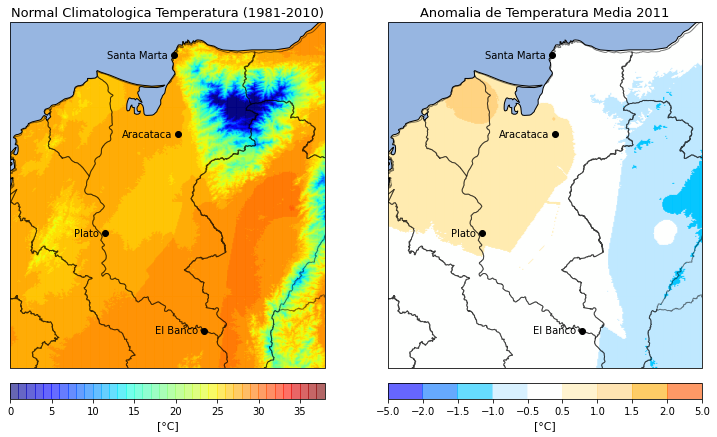

Output()

In [8]:
import ipywidgets as widgets
import time

a = widgets.Dropdown(options=[('Enero', 'ENE'), ('Febrero', 'FEB'), ('Marzo', 'MAR'), ('Abril', 'ABR'), ('Mayo', 'MAY'),
                             ('Junio', 'JUN'), ('Julio', 'JUL'), ('Agosto', 'AGO'), ('Septiembre', 'SEP'),
                             ('Octubre', 'OCT'), ('Noviembre', 'NOV'), ('Diciembre', 'DIC')], description='Mes:')
b = widgets.Dropdown(options=[2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021], description='Año:')
c = widgets.Dropdown(options=['Magdalena', 'Santander'], description='Dep:')
d = widgets.Dropdown(options=[('Anomalía', 'Anomalia'),   ('Valor Absoluto', 'Absoluto')], description='Tipo:')
e = widgets.Checkbox(value=False,description='Ver Valores',disabled=False,indent=False)
ui = widgets.HBox([a, b, c, d, e])
def f(a, b, c, d, e):
    start_time = time.time()
    if b == 2021 and a != 'ENE' and a != 'FEB' and a != 'MAR':
        print('No hay todavía gráficos para la información especificada.')
    else:    
        m = Mapa(c,b,a,d,e)
        m.plot_mapas()
    #print("--- %s seconds ---" % (time.time() - start_time))

out = widgets.interactive_output(f, {'a': a, 'b': b, 'c': c, 'd': d, 'e': e})

display(ui, out)

## Gráfico de Tendencia Nacional

In [9]:
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.linear_model import LinearRegression

#Se importa los datos
df = pd.read_csv(str(r".\Datos\Temperatura\Temperatura_Nacional_Anual.csv"))
df.Fecha = pd.to_datetime(df['Fecha'], format = '%d/%m/%Y')

fig = px.line(df, x="Fecha", y=["Normal Climatica (1980-2010)", "Temperatura del Aire"])
fig.update_traces(mode="markers+lines", hovertemplate=None)
fig.update_layout(hovermode="x unified", yaxis_title="°C (Grado Centígrado)", xaxis_title="Tiempo",
                 title_text="Temperatura Media de Colombia 1984-2021", title_x=0.22)

#Regresion Lineal
layoutAnnotationList = []
regr = LinearRegression()
x = np.array(range(len(df)))
y = np.array(df['Temperatura del Aire'])
regr.fit(x.reshape(-1, 1), y.reshape(-1, 1))
linear_regresion = regr.predict(x.astype(float).reshape(-1, 1))
slope_anual = regr.coef_[0][0]*10
text = 'y = '+str(round(slope_anual,2))+'x + '+str(round(regr.intercept_[0],2))+' [°C/decada]'
fig.add_trace((go.Scatter(x=df['Fecha'].tolist(),y=list(linear_regresion.ravel()), mode="lines", name='Regresion Lineal', 
                   legendgroup="group", visible = 'legendonly',line=dict(color="orange"))))    
layoutAnnotationList.append(dict(text=text, xref="x", yref="y",x='1995', y=min(y), showarrow=False, font=dict(color='darkorange',size = 14)))  

# Agregar Botones
layoutButtons = list([dict(type="buttons",active=-1,
                           buttons=list([   
                        dict(label = 'Regresion:On',
                             method = 'update',
                             args = [{'visible': [True, True, True, True]},{'annotations':layoutAnnotationList}]),
                        dict(label = 'Regresion:Off',
                            method = 'update',
                             args = [{'visible':[True, True, False, False]},{'annotations':[]}]),
                                        ]),
                           pad={"r": 10, "t": 10},showactive=True,x=1.04,xanchor="left",
                           y=0.015 ,yanchor="bottom"
                           )
                    ])

fig.update_layout(updatemenus=layoutButtons)

fig.show()

In [10]:
#Manejo datos de Estaciones Berlin
import pandas as pd
import datetime as dt
import numpy as np
import ast

meses = [10,12] # Octubre, Noviembre, Diciembre
valor = []

for mes in meses: 
    df = pd.read_csv(r".\Datos\Datos_Berlin.csv") #Se cargan los datos de Berlin
    df['timestamp'] = pd.to_datetime(df['timestamp']) #Se leen las fechas
    df.dropna(subset = ["temperature"], inplace=True) #Se remueven filas sin datos de temperatura 
    
    #Filtro 1. Se seleccionan los datos que se recolectaron entre octubre y diciembre de 2020
    mask = (df['timestamp'].dt.year == 2020) & (df['timestamp'].dt.month == mes) 
    filtro1_df = df.loc[mask]

    #Se selecciona solo primer dato en cada hora
    filtro1_df = filtro1_df.set_index('timestamp')
    filtro1_df = filtro1_df.groupby(filtro1_df.index.floor('H')).first()
    
    #Filtro 2. Se seleccionan los datos que se recolectaron a las 7, 13 y 18 horas
    mask2 = (filtro1_df.index.hour == 7) | (filtro1_df.index.hour == 13) | (filtro1_df.index.hour == 19)
    filtro2_df = filtro1_df.loc[mask2]
    
    #Se verifica que si existan 3 datos para cada dia
    for day in range(1,31):
        df2 = filtro2_df.loc[filtro2_df.index.day == day]
        if ~(df2['temperature'].count() == 3):
            filtro2_df = filtro2_df.drop(df2['temperature'].index.tolist())

    #Se extrae el valor de temperatura media
    temperatura = filtro2_df['temperature'].apply(lambda x: ast.literal_eval(x)['value'])
   
    #Se calcula el promedio mensual
    promedio_temperatura = temperatura.mean(skipna = True)

    #Se guarda en lista
    valor.append(promedio_temperatura)
    
print('Temperatura Media en Berlin (Santander)\n \n', 'Octubre de 2020: ', valor[0], '\n', 
      'Diciembre de 2020: ', valor[1], '\n')

Temperatura Media en Berlin (Santander)
 
 Octubre de 2020:  13.371 
 Diciembre de 2020:  12.048070175438596 



In [11]:
#####################################################################
# Se programa para que se esconda el código de este Jupyter Notebook
#####################################################################

In [12]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
El código de este cuaderno IPython está oculto de forma predeterminada para facilitar la lectura.
Para activar / desactivar el código sin formato, haga clic <a href="javascript:code_toggle()">aqui</a>.''')